In [1]:
import os
import sys
import random
import numpy as np
# import cv2
import matplotlib
import matplotlib.pyplot as plt

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.config import Config

import skimage
%load_ext autoreload
%autoreload 2
    
%matplotlib inline 

# Root directory of the project
ROOT_DIR = '/home/sky8/cal/'
# ROOT_DIR2 = '/data1/share/shiky/Mask_RCNN'
img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR2, "mask_rcnn_coco.h5")


/home/sky8/calcification/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class CalConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "calcification"

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (750 - 20) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, 20 // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400
    
config = CalConfig()
config.display()   
 



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           calcification
NUM_CLASSES                    2
POOL_SIZE                      7
P

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_middle= full_name.split('.')[0]
            mask_name = mask_middle + '_MASK.jpg'
            mask_path = os.path.join(mask_dir, mask_name)
            
            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)
#     def load_image(self, image_id):
#         """load image from local path"""
        
#         info = self.image_info[image_id]
       
#         image = skimage.io.imread(info.path)
        
#         return image
        
    def load_mask(self, image_id):
        """load the mask image"""
        
        info = self.image_info[image_id]
        
       
        mask = skimage.io.imread(info['mask_path']).astype(bool)
        mask = mask[:,:,np.newaxis]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("calcification")])
        
        return mask, class_ids.astype(np.int32)
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [5]:
# Training dataset
dataset_train = CalDataset()
dataset_train.load_cal(753, img_train, mask_train, train_imglist)
dataset_train.prepare()

# Validation dataset
dataset_val = CalDataset()
dataset_val.load_cal(200, img_val, mask_val, val_imglist)
dataset_val.prepare()

In [51]:
import tensorflow

In [52]:
!which python

/home/sky8/calcification/bin/python


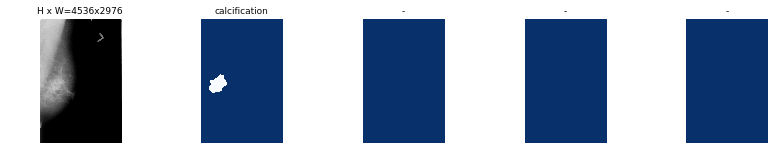

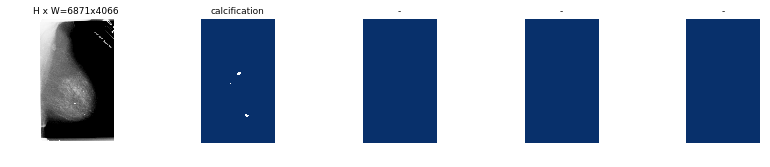

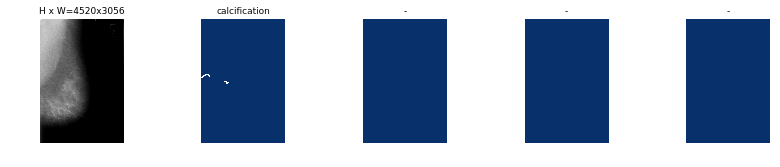

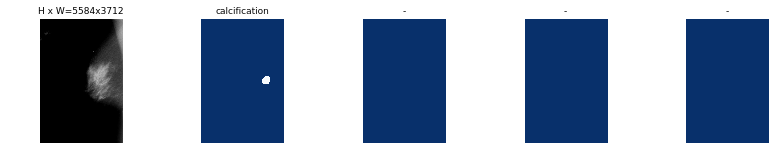

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) 

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16806468826840211887
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11850914202
locality {
  bus_id: 1
}
incarnation: 6136905579258723424
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0"
]


In [7]:
!nvidia-smi

Wed Apr 18 07:10:04 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |  11599MiB / 12193MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [57]:
# Load the last model you trained and continue training
# model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
model_path = model.find_last()[1]
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/sky8/cal/logs/calcification20180418T0710/mask_rcnn_calcification_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/home/sky8/calcification/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
364/365 [============================>.] - ETA: 3s - loss: 6.8831 - rpn_class_loss: 0.3878 - rpn_bbox_loss: 5.3883 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.8589 - mrcnn_mask_loss: 0.2266

/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


365/365 [==============================] - 1508s 4s/step - loss: 6.8800 - rpn_class_loss: 0.3876 - rpn_bbox_loss: 5.3883 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.8565 - mrcnn_mask_loss: 0.2259 - val_loss: 4.6057 - val_rpn_class_loss: 0.2188 - val_rpn_bbox_loss: 3.1475 - val_mrcnn_class_loss: 0.0254 - val_mrcnn_bbox_loss: 0.8688 - val_mrcnn_mask_loss: 0.3452
Epoch 2/20
365/365 [==============================] - 1174s 3s/step - loss: 3.6758 - rpn_class_loss: 0.1606 - rpn_bbox_loss: 2.3178 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.8163 - mrcnn_mask_loss: 0.3480 - val_loss: 3.2925 - val_rpn_class_loss: 0.1525 - val_rpn_bbox_loss: 1.3459 - val_mrcnn_class_loss: 0.0699 - val_mrcnn_bbox_loss: 1.1864 - val_mrcnn_mask_loss: 0.5378
Epoch 3/20
365/365 [==============================] - 1191s 3s/step - loss: 2.5564 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 1.1843 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.7844 - mrcnn_mask_loss: 0.4201 - val_loss: 3.2361 - val_rpn_class_loss: 0.1

Process Process-23:
Process Process-21:
Process Process-2:
Process Process-30:
Process Process-33:
Process Process-19:
Process Process-18:
Process Process-17:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-14:
Process Process-29:
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap

  File "/home/sky8/cal/code/Mask_RCNN/mrcnn/utils.py", line 453, in resize_image
    order=1, mode="constant", preserve_range=True)
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/io/_plugins/pil_plugin.py", line 37, in imread
    return pil_to_ndarray(im, dtype=dtype, img_num=img_num)
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/transform/_warps.py", line 135, in resize
    preserve_range=preserve_range)
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/io/_plugins/pil_plugin.py", line 53, in pil_to_ndarray
    im.getdata()[0]
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/transform/_warps.py", line 775, in warp
    order=order, mode=mode, cval=cval))
  File "/home/sky8/calcification/lib/python3.5/site-packages/skimage/transform/_warps.py", line 775, in war

KeyboardInterrupt: 

In [9]:
!export OMP_NUM_THREADS=1

In [1]:
!printenv OMP_NUM_THREADS

1


In [7]:
!ls

assets		     core.10213  core.4602    mask_rcnn.egg-info  setup.cfg
build		     core.12712  dist	      mrcnn		  setup.py
cal_data.ipynb	     core.13867  images       README.md		  testgpu.ipynb
cal_Mask_rcnn.ipynb  core.23345  LICENSE      requirements.txt
cal_weights.ipynb    core.30489  MANIFEST.in  samples


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")


Starting at epoch 2. LR=0.0002

Checkpoint Path: /home/sky8/cal/logs/cal20180418T0238/mask_rcnn_cal_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

/home/sky8/calcification/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 3/4
 99/100 [============================>.] - ETA: 3s - loss: 5.1318 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 4.1992 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.5954 - mrcnn_mask_loss: 0.2063

/home/sky8/calcification/lib/python3.5/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 486s 5s/step - loss: 5.1256 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 4.1810 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.2115 - val_loss: 3.9852 - val_rpn_class_loss: 0.0677 - val_rpn_bbox_loss: 2.8622 - val_mrcnn_class_loss: 0.0376 - val_mrcnn_bbox_loss: 0.6053 - val_mrcnn_mask_loss: 0.4124
Epoch 4/4
100/100 [==============================] - 267s 3s/step - loss: 3.2382 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 2.5384 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.2165 - val_loss: 3.5040 - val_rpn_class_loss: 0.0632 - val_rpn_bbox_loss: 2.9003 - val_mrcnn_class_loss: 0.0629 - val_mrcnn_bbox_loss: 0.3297 - val_mrcnn_mask_loss: 0.1479


In [5]:
!nvidia-smi

Tue Apr 17 08:50:09 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 12193MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
!top

=top - 18:10:31 up 5 days,  8:13,  1 user,  load average: 0.06, 0.06, 0.07
Tasks: 197 total,   1 running, 196 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.7 us,  1.4 sy,  0.0 ni, 97.7 id,  0.1 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 16268444 total,  7866836 free,  4583072 used,  3818536 buff/cache
KiB Swap: 10000380 total,  9739728 free,   260652 used. 10956968 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
 3472 root      20   0 18.382g 1.071g 246584 S  13.3  6.9   0:26.48 python      
 3547 root      20   0  663300  56140  12404 S   6.7  0.3   0:02.21 python      
    1 root      20   0  185472   3908   2492 S   0.0  0.0  15:26.80 systemd     
    2 root      20   0       0      0      0 S   0.0  0.0   0:00.02 kthreadd    
    4 root       0 -20       0      0      0 S   0.0  0.0   0:00.00 kworker/0:+ 
    6 root       0 -20       0      0      0 S   0.0  0.0   0:00.00 mm_percpu_+ 
    7 root      20   0       0      0      0 S   0.0  0

## Detection

In [12]:
class InferenceConfig(CalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
# model_path = "/data1/share/shiky/Mask_RCNN/data/logs/cal20180402T1742/mask_rcnn_cal_0009.h5"
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/sky8/cal/logs/cal20180418T0238/mask_rcnn_cal_0004.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4584.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   54.00000  max:   98.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


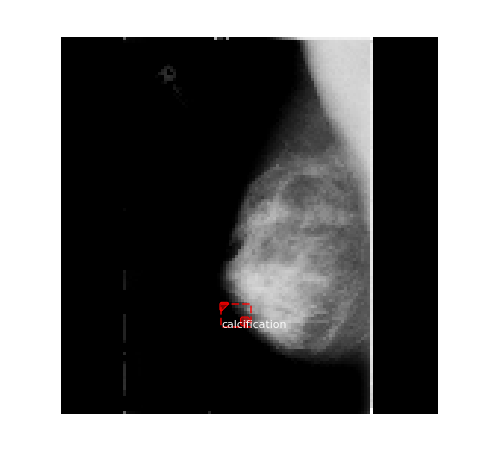

'P_01440_RIGHT_MLO.jpg'

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

output = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))
# skimage.io.imsave('/data1/share/shiky/Mask_RCNN/test2.jpg', output)
# # 	plt.savefig("/data1/share/shiky/Mask_RCNN/test.jpg")
# # print(output)
# mask, class_ids = dataset_val.load_mask(image_id)


# mask = mask.astype('uint8')


# mask[mask == 1] = 255
# mask = mask[:, :, 0]
# # cv2.imshow('mask',mask)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.figure(figsize=(13,13))
# plt.imshow(mask, cmap='gray')
dataset_val.load_name(image_id)

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


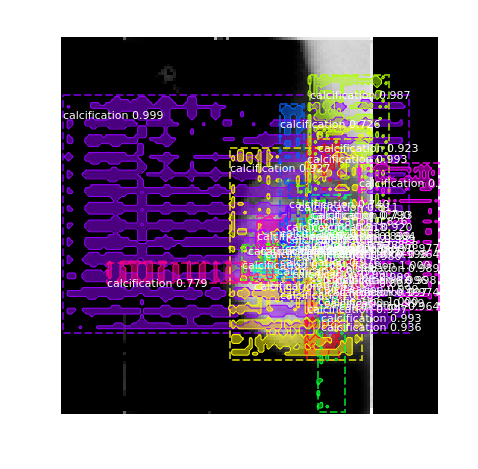

In [14]:
results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [73]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    print(image_id)
#     log("image", image)
#     log("mask", gt_mask)
#     log("class_ids", gt_class_id)
#     log("bbox", gt_bbox)
#     # Display image and instances
#     visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

191


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


187
160
19
34
177
49
98
48
5
100
0
139
40
95
46
24
13
137
103
137
177
64
197
70
149
89
61
105
178
112
108
112
183
95
132
185
20
125
7
81
173
146
33
182
151
34
76
30
65
mAP:  0.060580086580086574


In [3]:
!rm -r /data1/share/shiky/Mask_RCNN/data/logs/*

rm: cannot remove '/data1/share/shiky/Mask_RCNN/data/logs/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0023.h5': No such file or directory


In [3]:
!ls /data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/*

/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0001.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0002.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0003.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0004.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0005.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0006.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0007.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0008.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0009.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0010.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0011.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcnn_cal_0012.h5
/data1/share/shiky/Mask_RCNN/data/logs/cal20180403T1256/mask_rcn